In [1]:
import os
from pcxarray import pc_query, prepare_data
from pcxarray.utils import load_census_shapefile
from distributed import Client
import matplotlib.pyplot as plt

In [2]:
states_gdf = load_census_shapefile(level='state', verify=False)
ms_gdf = states_gdf[states_gdf['NAME'] == 'Mississippi']
ms_gdf = ms_gdf.to_crs(epsg=3814)
geom = ms_gdf.geometry.union_all()

Found 10 items in the GNATSGO collection.


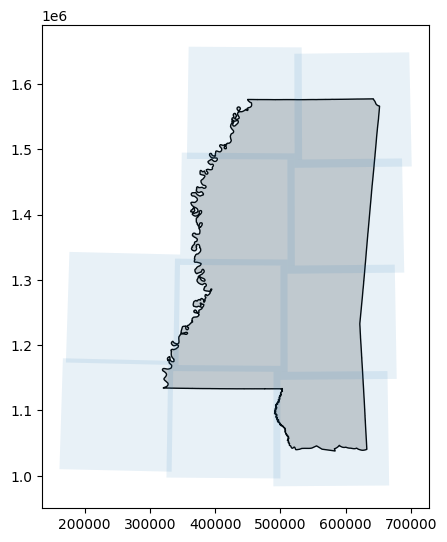

In [3]:
items_gdf = pc_query(
    collections='gnatsgo-rasters',
    geometry=geom,
    crs=ms_gdf.crs,
)
print(f"Found {len(items_gdf)} items in the GNATSGO collection.")

fig, ax = plt.subplots(figsize=(5, 10))
ms_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
items_gdf.plot(ax=ax, alpha=0.1)
plt.show()

In [4]:
client = Client(n_workers=os.cpu_count(), memory_limit="4GB")
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 37.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60823,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:60846,Total threads: 1
Dashboard: http://127.0.0.1:60850/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:60826,


In [5]:
nccpi_da = prepare_data(
    items_gdf,
    geometry=geom,
    crs=ms_gdf.crs,
    bands=['nccpi3corn', 'nccpi3cot', 'nccpi3soy'],
    enable_progress_bar=True,
    target_resolution=250, # 250 m resolution
    reproject_first=True, # reproject/resample prior to merging - reduce memory footprint
    reproject_num_threads=-1, # use all available CPUs for reprojection
    reproject_mem_limit=256, # 256 MB memory limit for reprojection
    masked=True,
    chunks={'x': 1024, 'y': 1024},
)

Merging tiles:   0%|          | 0/10 [00:00<?, ?tiles/s]/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 354.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Merging tiles:  10%|█         | 1/10 [00:41<06:09, 41.00s/tiles]/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 274.96 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Merging tiles:  20%|

In [6]:
nccpi_da_filled = nccpi_da.rio.interpolate_na(method='linear')
nccpi_da_filled = nccpi_da_filled.rio.clip([geom], crs=ms_gdf.crs)

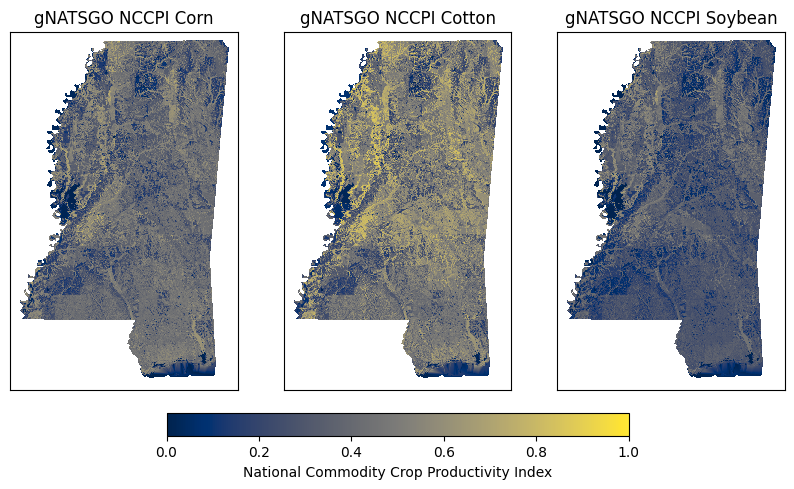

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(10, 15), sharex=True, sharey=True)

nccpi_da_filled.sel(band='nccpi3corn').plot.imshow(ax=ax[0], cmap='cividis', vmin=0, vmax=1, add_colorbar=False)
nccpi_da_filled.sel(band='nccpi3cot').plot.imshow(ax=ax[1], cmap='cividis', vmin=0, vmax=1, add_colorbar=False)
nccpi_da_filled.sel(band='nccpi3soy').plot.imshow(ax=ax[2], cmap='cividis', vmin=0, vmax=1, add_colorbar=False)

for a in ax:
    a.set_aspect('equal')
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel('')
    a.set_ylabel('')
    
    # pad the axes to avoid overlap
    a.set_xlim(a.get_xlim()[0] - 5000, a.get_xlim()[1] + 5000)
    a.set_ylim(a.get_ylim()[0] - 5000, a.get_ylim()[1] + 5000)

# ax[0].set_aspect('equal')
ax[0].set_title('gNATSGO NCCPI Corn')

ax[1].set_title('gNATSGO NCCPI Cotton')

ax[2].set_title('gNATSGO NCCPI Soybean')

fig.colorbar(ax[0].images[0], ax=ax, orientation='horizontal', fraction=0.02, pad=0.02, label='National Commodity Crop Productivity Index')
# fig.tight_layout()